In [87]:
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dataseets
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
#from PIL import image
import PIL.ImageOps
import pandas as pd
import time
from collections import Counter


from pytorch_metric_learning import losses, miners, samplers

In [35]:
t = transforms.Compose([
                       transforms.Resize((100,100)),
                       transforms.ToTensor(),
                       transforms.Normalize(mean=(0), std=(1))]
                       )

In [36]:
dataset = torchvision.datasets.LFWPeople(root = './LFW/', split = "train", download = True, transform = t)
dataset_test = torchvision.datasets.LFWPeople(root = './LFW/', split = "test", download = True, transform = t )

Files already downloaded and verified
Files already downloaded and verified


In [37]:
dataset_train, dataset_val = torch.utils.data.random_split(dataset, [8573, 952])

In [100]:
label_train = []
label_val   = []
label_test  = []

for i in range(0,len(dataset_train)):
    label_train.append(dataset_train[i][1])
    
for i in range(0,len(dataset_val)):
    label_val.append(dataset_val[i][1])
    
for i in range(0,len(dataset_test)):
    label_test.append(dataset_test[i][1])

In [101]:
num_class_train = len(np.unique(label_train))
num_class_val   = len(np.unique(label_val))
num_class_test = len(np.unique(label_test))

In [40]:
dataset_test[4][1]

15

In [102]:
smpl_train = samplers.MPerClassSampler(label_train, m=2, length_before_new_iter = len(dataset_train))
smpl_val   = samplers.MPerClassSampler(label_val,   m=2, length_before_new_iter = len(dataset_val))
smpl_test   = samplers.MPerClassSampler(label_test, m=2, length_before_new_iter = len(dataset_test))

In [103]:
dataloader_train = DataLoader(dataset_train,
                              shuffle = False,
                              num_workers = 0,
                              batch_size = 16,
                              sampler = smpl_train)

dataloader_val = DataLoader(dataset_val,
                              shuffle = False,
                              num_workers = 0,
                              batch_size = 16,
                              sampler = smpl_val)

dataloader_test = DataLoader(dataset_test,
                              shuffle = False,
                              num_workers = 0,
                              batch_size = 2,
                              sampler = smpl_test)

example_batch = next(iter(dataloader_train))

[2851 2851 4359 4359 1343 1343 5434 5434 4838 4838 4969 4969 5680 5680
  265  265]


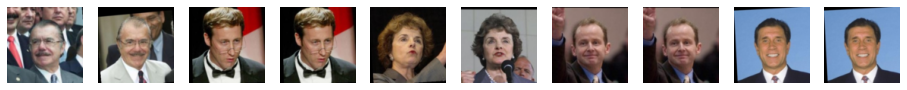

In [63]:
fig, ax = plt.subplots(1, 10, figsize = (16, 6))
for i in range(0, 10):
    ax[i].imshow(example_batch[0][i].permute(1,2,0))
    #ax[1][i].imshow(example_batch[1][i].permute(1,2,0))

    
for i in range(0, 10):
    ax[i].axis('off')
    #ax[1][i].axis('off')

print(example_batch[1].numpy().reshape(-1))

[ 694  694  498  498 3079 3079 1768 1768 5465 5465 1198 1198 2383 2383
 5140 5140]


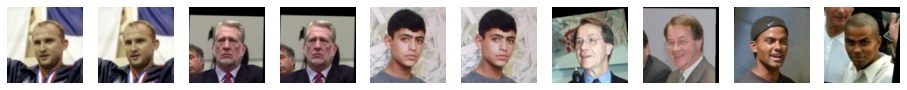

In [53]:
fig, ax = plt.subplots(1, 10, figsize = (16, 6))
for i in range(0, 10):
    ax[i].imshow(example_batch[0][i].permute(1,2,0))
    #ax[1][i].imshow(example_batch[1][i].permute(1,2,0))

    
for i in range(0, 10):
    ax[i].axis('off')
    #ax[1][i].axis('off')

print(example_batch[1].numpy().reshape(-1))

In [64]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.cnn1 = nn.Sequential(
        
            nn.Conv2d(3, 96, kernel_size = 11, stride = 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride = 2),
            
            nn.Conv2d(96, 256,kernel_size = 5, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            
            nn.Conv2d(256, 384, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True)
        
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(384,1024),
            nn.ReLU(inplace = True),
        
            nn.Linear(1024, 512),
            nn.ReLU(inplace = True),
            
            nn.Linear(512, 256),
            nn.ReLU(inplace = True),
        
        )
        
        
    def forward(self, x):
        output = self.cnn1(x)
        #print(output.shape)
        #print("size:", output.view(output.size()[0],-1).shape)
        output = self.fc1(output.view(output.size()[0],-1))
        #print(output.shape)
        return output
    

In [65]:
n = Network()

In [120]:
net = Network().cuda()
criterion = losses.TripletMarginLoss()
miner = miners.MultiSimilarityMiner()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

In [121]:
iter_num = []

epoch_loss_train = []
epoch_loss_val = []

count = 0

len_train = len(dataloader_train)
len_val = len(dataloader_val)

since = time.time()

for epoch in range(100):
    #train
    total_loss = 0
    for i, (img, label) in enumerate(dataloader_train, 0):
        img, label = img.cuda().float(), label.cuda().float()

        optimizer.zero_grad()
        
        embedding = net(img)
        #print(embedding.shape)
        
        hard_pairs = miner(embedding,label)
        #print("hard_pairs", hard_pairs)
        
        loss = criterion(embedding, label, hard_pairs)
    
        loss.backward()
        
        optimizer.step()
        
        
        total_loss += loss.item()
    
    epoch_loss_train.append(total_loss/len_train)
    
    #validation
    total_loss_val = 0
    for j, (img, label) in enumerate(dataloader_val, 0):
        img, label = img.cuda().float(), label.cuda().float()

        optimizer.zero_grad()
        
        embedding = net(img)
        #print(embedding.shape)
        
        hard_pairs = miner(embedding,label)
        #print("hard_pairs", hard_pairs)
        
        loss = criterion(embedding, label, hard_pairs)
    
        #loss.backward()
        
        #optimizer.step()
        
        
        total_loss_val += loss.item()
    
    print(f"Epoch:{epoch} -> train loss:{total_loss/len_train} ,validation loss:{total_loss_val/len_val}")
    epoch_loss_val.append(total_loss_val/len_val)
time_elapsed = time.time() - since

Epoch:0 -> train loss:0.04659035318876104 ,validation loss:0.06529414172594745
Epoch:1 -> train loss:0.04682269841691826 ,validation loss:0.04224560132715851
Epoch:2 -> train loss:0.04599867107414459 ,validation loss:0.04879138395190239
Epoch:3 -> train loss:0.04576556917232096 ,validation loss:0.04696348866758247
Epoch:4 -> train loss:0.04557062613895478 ,validation loss:0.05478225378319621
Epoch:5 -> train loss:0.043995487166676325 ,validation loss:0.049975259532220664
Epoch:6 -> train loss:0.04454807377803265 ,validation loss:0.048407014536981784
Epoch:7 -> train loss:0.04467326998152238 ,validation loss:0.05649498862524827
Epoch:8 -> train loss:0.042886415981075364 ,validation loss:0.050538753842314085
Epoch:9 -> train loss:0.04227995577346079 ,validation loss:0.06598338599627217
Epoch:10 -> train loss:0.043255234376489475 ,validation loss:0.05488530832032363
Epoch:11 -> train loss:0.04299994304425201 ,validation loss:0.05474387418944389
Epoch:12 -> train loss:0.04323257468351636 ,

In [122]:
time_elapsed / 60

23.012016105651856

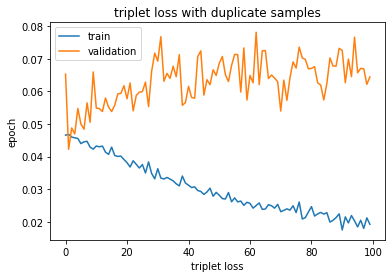

In [123]:
plt.plot(epoch_loss_train)
plt.plot(epoch_loss_val)
plt.title('triplet loss with duplicate samples')
plt.xlabel('triplet loss')
plt.ylabel('epoch')
plt.legend(['train', 'validation']);

In [104]:
dataiter = iter(dataloader_test)
x1, l1 = next(dataiter)

In [105]:
dataiter = iter(dataloader_test)
x2, l2 = next(dataiter)

tensor([2.2678], device='cuda:0', grad_fn=<NormBackward1>)


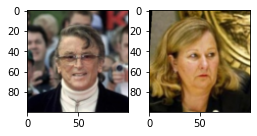

In [106]:
fig, ax = plt.subplots(1, 2, figsize = (4, 4))

output1 = net(x1[0].unsqueeze(0).cuda())
output2 = net(x2[0].unsqueeze(0).cuda())
euclidean_distance = F.pairwise_distance(output1, output2)

ax[0].imshow(x1[0].permute(1,2,0))
ax[1].imshow(x2[0].permute(1,2,0))
print(euclidean_distance)

tensor([1.7156], device='cuda:0', grad_fn=<NormBackward1>)


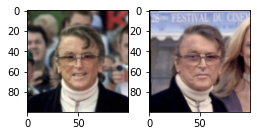

In [107]:
fig, ax = plt.subplots(1, 2, figsize = (4, 4))

output1 = net(x1[0].unsqueeze(0).cuda())
output2 = net(x1[1].unsqueeze(0).cuda())
euclidean_distance = F.pairwise_distance(output1, output2)


ax[0].imshow(x1[0].permute(1,2,0))
ax[1].imshow(x1[1].permute(1,2,0))
print(euclidean_distance)

Part2: only classes with more than 2 samples

In [88]:
def key_func(dataset, s_count = 1):
    
    key = []
    
    targets = [s[1] for s in dataset]
    d = dict(Counter(targets))
    for i in d:
        if d[i]>s_count:
            key.append(i)    
    return key

In [89]:
def new_dataset(dataset):
    img_d = []
    label_d = []
    key = key_func(dataset)
    for img,l in dataset:
        if l in key: 
            img_d.append(img)
            label_d.append(l)
    d_new = list(zip(img_d,label_d))
    return d_new
    

In [90]:
train_dataset_2 = new_dataset(dataset_train)
val_dataset_2   = new_dataset(dataset_val)
test_dataset_2  = new_dataset(dataset_test)

In [91]:
def label_func(dataset):
    targets = [s[1] for s in dataset]
    return targets

In [92]:
train_label_2 = label_func(train_dataset_2)
val_label_2   = label_func(val_dataset_2)
test_label_2  = label_func(test_dataset_2)

In [108]:
smpl_train_2 = samplers.MPerClassSampler(train_label_2, m=2, length_before_new_iter = len(train_label_2))
smpl_val_2   = samplers.MPerClassSampler(val_label_2,   m=2, length_before_new_iter = len(val_label_2))
smpl_test_2   = samplers.MPerClassSampler(test_label_2,   m=2, length_before_new_iter = len(test_label_2))

In [109]:
dataloader_train_2 = DataLoader(train_dataset_2,
                              shuffle = False,
                              num_workers = 0,
                              batch_size = 16,
                              sampler = smpl_train_2)

dataloader_val_2 = DataLoader(val_dataset_2,
                              shuffle = False,
                              num_workers = 0,
                              batch_size = 16,
                              sampler = smpl_val_2)

dataloader_test_2 = DataLoader(test_dataset_2,
                              shuffle = False,
                              num_workers = 0,
                              batch_size = 4,
                              sampler = smpl_test_2)

example_batch = next(iter(dataloader_train_2))

[2986 2986 5494 5494  794  794 2403 2403 4429 4429 3039 3039 5672 5672
 2491 2491]


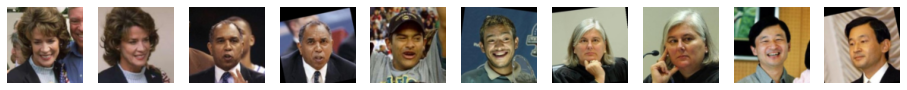

In [95]:
fig, ax = plt.subplots(1, 10, figsize = (16, 6))
for i in range(0, 10):
    ax[i].imshow(example_batch[0][i].permute(1,2,0))
    #ax[1][i].imshow(example_batch[1][i].permute(1,2,0))

    
for i in range(0, 10):
    ax[i].axis('off')
    #ax[1][i].axis('off')

print(example_batch[1].numpy().reshape(-1))

In [96]:
net_2 = Network().cuda()
criterion_2 = losses.CircleLoss()
miner_2 = miners.MultiSimilarityMiner()
optimizer_2 = optim.Adam(net.parameters(), lr = 0.0001)

In [97]:
epoch_loss_train_2 = []
epoch_loss_val_2 = []

count_2 = 0

len_train_2 = len(dataloader_train_2)
len_val_2 = len(dataloader_val_2)

since_2 = time.time()

for epoch in range(100):
    #train
    total_loss = 0
    for i, (img, label) in enumerate(dataloader_train_2, 0):
        img, label = img.cuda().float(), label.cuda().float()

        optimizer_2.zero_grad()
        
        embedding = net(img)
        #print(embedding.shape)
        
        hard_pairs = miner(embedding,label)
        #print("hard_pairs", hard_pairs)
        
        loss = criterion(embedding, label, hard_pairs)
    
        loss.backward()
        
        optimizer.step()
        
        
        total_loss += loss.item()
    
    epoch_loss_train_2.append(total_loss/len_train_2)
    
    #validation
    total_loss_val = 0
    for j, (img, label) in enumerate(dataloader_val_2, 0):
        img, label = img.cuda().float(), label.cuda().float()

        optimizer_2.zero_grad()
        
        embedding = net(img)
        #print(embedding.shape)
        
        hard_pairs = miner(embedding,label)
        #print("hard_pairs", hard_pairs)
        
        loss = criterion(embedding, label, hard_pairs)
    
        #loss.backward()
        
        #optimizer.step()
        
        
        total_loss_val += loss.item()
    
    print(f"Epoch:{epoch} -> train loss:{total_loss/len_train_2} ,validation loss:{total_loss_val/len_val_2}")
    epoch_loss_val_2.append(total_loss_val/len_val_2)
time_elapsed_2 = time.time() - since_2

Epoch:0 -> train loss:0.04502402272705427 ,validation loss:0.10487087177378791
Epoch:1 -> train loss:0.037146627577706516 ,validation loss:0.09146402589976788
Epoch:2 -> train loss:0.0402489310123629 ,validation loss:0.09577132069638797
Epoch:3 -> train loss:0.039266937224002665 ,validation loss:0.10557169307555471
Epoch:4 -> train loss:0.038214716762441266 ,validation loss:0.09555953395153795
Epoch:5 -> train loss:0.035112238410339856 ,validation loss:0.10016949714294501
Epoch:6 -> train loss:0.03642696509760914 ,validation loss:0.10468767955899239
Epoch:7 -> train loss:0.037804729945492 ,validation loss:0.11643943030919347
Epoch:8 -> train loss:0.03580610457164071 ,validation loss:0.10134429591042655
Epoch:9 -> train loss:0.036371600605300904 ,validation loss:0.0958141910710505
Epoch:10 -> train loss:0.03831088526845526 ,validation loss:0.09203413927129336
Epoch:11 -> train loss:0.037405702160493305 ,validation loss:0.1025735427226339
Epoch:12 -> train loss:0.038665260164313674 ,vali

In [98]:
time_elapsed_2 / 60

3.5355579972267153

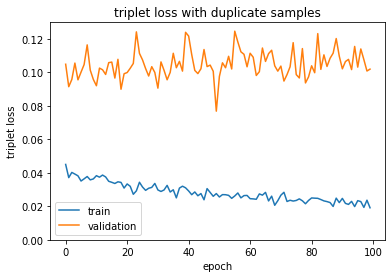

In [125]:
plt.plot(epoch_loss_train_2)
plt.plot(epoch_loss_val_2)
plt.ylim(ymin=0) 
plt.title('triplet loss with duplicate samples')
plt.xlabel('epoch')
plt.ylabel('triplet loss')
plt.legend(['train', 'validation']);

In [115]:
dataiter = iter(dataloader_test_2)
x1, l1 = next(dataiter)

In [116]:
dataiter = iter(dataloader_test)
x2, l2 = next(dataiter)

tensor([0.0145], device='cuda:0', grad_fn=<NormBackward1>)


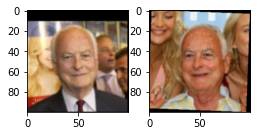

In [117]:
fig, ax = plt.subplots(1, 2, figsize = (4, 4))

output1 = net_2(x1[0].unsqueeze(0).cuda())
output2 = net_2(x1[1].unsqueeze(0).cuda())
euclidean_distance = F.pairwise_distance(output1, output2)

ax[0].imshow(x1[0].permute(1,2,0))
ax[1].imshow(x1[1].permute(1,2,0))
print(euclidean_distance)

tensor([0.0186], device='cuda:0', grad_fn=<NormBackward1>)


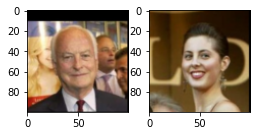

In [118]:
fig, ax = plt.subplots(1, 2, figsize = (4, 4))

output1 = net_2(x1[0].unsqueeze(0).cuda())
output2 = net_2(x2[1].unsqueeze(0).cuda())
euclidean_distance = F.pairwise_distance(output1, output2)

ax[0].imshow(x1[0].permute(1,2,0))
ax[1].imshow(x2[0].permute(1,2,0))
print(euclidean_distance)